In [12]:
import cv2
import os
import shutil
import colorsys
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

In [18]:
def findLimits(frame):
    # Let's find the red objects in the scene
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    h,_,_ = cv2.split(hsv_frame)
    lower_red = np.array([0,150,150]) #example value
    upper_red = np.array([20,255,255]) #example value
    red = cv2.inRange(hsv_frame, lower_red, upper_red)
    red = cv2.bitwise_not(red)
    
    # Finding the possition of the two red marks in the scene
    keypoints = detector2.detect(red)
    marks = []
    copied_im = cv2.cvtColor(red.copy(), cv2.COLOR_GRAY2BGR)
    for k in keypoints:
        x, y = k.pt
        marks.append((int(x), int(y)))
    return marks

def isEmpty(scene):
    ''' Checks if in the current frame there is someone using the histogram of a blank laboratory '''
    hsv_scene = cv2.cvtColor(scene,cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv_scene)
    H_array = H[S > 100].flatten()
    val, pos = np.histogram(H_array, 18)
    val[[0,3]] = 0
#     print(val[[4,5,7,8,12,13,14,15,16]].max())
    return val.max()<1000

def create_dir(folder, force=True, verbose=False):
    '''   Create a directory if it doesn't exist  '''
    try:
        os.makedirs(folder)
        if verbose: print('Directory {} created succesfully.'.format(folder))   
    except:
        if force:
            if verbose: print('{} already exists. Creating a new one'.format(folder))
            shutil.rmtree(folder)
            os.makedirs(folder)
        else:
            if verbose: print('{} already exists.'.format(folder))
            pass
def bkgrd_hsv_substraction(frgrd, bkgrd):
    ''' Performs background substraction using the HLS color space '''
    bkgrd_hsv = cv2.cvtColor(bkgrd, cv2.COLOR_BGR2HLS)
    frgrd_hsv = cv2.cvtColor(frgrd, cv2.COLOR_BGR2HLS)

    diff = cv2.subtract(bkgrd_hsv, frgrd_hsv)
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, raw = cv2.threshold(diff_gray, 15, 255, cv2.THRESH_BINARY)
    if diff_gray.sum()> 400000:
        closed = fine_mask(raw)
        blured = cv2.GaussianBlur(closed,(3,3),0)
        return True, raw, closed, blured
    else:
        # print('Error: Small area of foreground')
        return False, None, None, None
    
kernel = np.ones((5,5),np.uint8)
def bkgrd_Lab_substraction(frame, background, th=5):
    ''' Performs background substraction using the Lab color space '''
    bkgrd_h = (cv2.cvtColor(background, cv2.COLOR_BGR2Lab))
    frgrd_h = (cv2.cvtColor(frame, cv2.COLOR_BGR2Lab))

    diff = cv2.subtract(bkgrd_h, frgrd_h)
    diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, diff = cv2.threshold(diff, 5, 255, cv2.THRESH_BINARY)
    diff = cv2.morphologyEx(diff, cv2.MORPH_CLOSE, kernel)
    if diff.sum() / 1000000 > th:
        closed = fine_mask(diff)
        blured = cv2.GaussianBlur(closed,(3,3),0)
        closed = cv2.multiply(diff, closed)
        return True, diff, closed, blured
    else:
        # print('Error: Small area of foreground')
        return False, None, None, None
    
def fine_mask(mask):
    ''' Takes a raw mask as input and returns the biggest contour mask '''
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    c = max(contours, key = cv2.contourArea)
    out = np.zeros_like(mask)
    out = cv2.drawContours(out, [c], 0, 255, -1)
    return out


def random_colors(N, bright=True):
    ''' Generate random colors  '''
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    # random.shuffle(colors)
    return colors

color = random_colors(1)[0]

def apply_mask(image, mask, color, alpha=0.5):
    ''' Apply the given mask to the image '''
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [14]:
clips_directory = '/home/israel/Downloads/UCB/clips'
raw_directory = '/home/israel/Downloads/UCB/raw'
subjects = sorted(os.listdir(os.path.join(raw_directory, '090')))
np.array(subjects)

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
       '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '5', '50', '51', '52', '53', '6', '7', '8', '9'], dtype='<U2')

In [19]:
views = ['090']
walks = {'nm':'1.mp4', 'bg':'2.mp4', 'cl':'3.mp4'}
# walks = {'cl':'3.mp4'}

In [21]:
subject_new = False   # Creates a new directory for each subject [001, ... , ]
walk_new = True       # Creates a new directory for each walking [nm, bg, cl]
empty_first = False    # True if the first frame is background
already_background = False
for view in views:
    print(f'PROCESSING VIEW: {view}')
    for subject in ['1']:
#     for subject in skip_sub:
        for walk, file in walks.items():
            print(f'Processing subject:{subject} walking: {walk} view: {view}')
            video_path = os.path.join(raw_directory, view, subject, file)
            cap = cv2.VideoCapture(video_path)
            wait = int(1000 / cap.get(cv2.CAP_PROP_FPS))

            sub_dir = os.path.join(clips_directory, view, str(subject).zfill(3))
            create_dir(sub_dir, force=subject_new)

            clip_dir = os.path.join(clips_directory, view, str(subject).zfill(3), walk)
            create_dir(clip_dir, force=walk_new)

            # Identify the background of each sequence using the 'isEmpty()' function
            cnt = 0
            background = None

            while True:
                ret, first = cap.read()
                if ret:
                    if already_background: 
                        break
                    if empty_first:
                        background = first
                        break
                    if cnt%10 == 0 and isEmpty(first):
#                         background = first
                        break
                    cnt+=1
                else:
                    print('Not background fount')
                    break
            cap.set(cv2.CAP_PROP_POS_FRAMES, cnt+30)
            ret, background = cap.read()
            # Saving the background image
            back_name = os.path.join(clip_dir, f'background.png')
            if not already_background: 
                cv2.imwrite(back_name, background)
            else:
                background = cv2.imread(back_name)

            # Defining parameters to split each video
            cap.set(cv2.CAP_PROP_POS_FRAMES, 1)
            cnt = 0
            nwalking = 1
            isWalking = False
            x = deque(10*[True],10)

            # Getting parameters for the video clips
            codec = cv2.VideoWriter_fourcc('M','J','P','G')
            fwidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            fheight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = int(cap.get(cv2.CAP_PROP_FPS))

            while True:
                ret, scene = cap.read()
                if ret:
                    if cnt%3 == 0:
                        isempty,_,_,_ = bkgrd_Lab_substraction(scene, background, th=4)
                        x.appendleft(not isempty) 
                        if np.average(x)>0.5:
                            if isWalking:
                                print(f'|')
                                isWalking = False
                                out.release()
                        elif not isWalking:
                            print(f'Sequence {nwalking}', end='')
                            isWalking = True
                            clip_name = os.path.join(clip_dir, f'{walk}-{str(nwalking).zfill(2)}.avi')
                            out = cv2.VideoWriter(clip_name, codec, fps, (fwidth,fheight))
                            nwalking +=1
                    if isWalking:
                        out.write(scene)
                        if cnt%10==0: print('.', end='')
                    cnt+=1         
    #                 cv2.imshow(f'Subject {subject}', scene)
                else:
                    print(f'|')
                    break
                if cv2.waitKey(1) == ord('q'):
                    break
            out.release()
            cap.release()
            cv2.destroyAllWindows()

PROCESSING VIEW: 090
Processing subject:1 walking: nm view: 090
Sequence 1............|
Sequence 2.........|
Sequence 3.................|
Sequence 4................|
Sequence 5.................|
Sequence 6.................|
Sequence 7..................|
Sequence 8.................|
Sequence 9...............|
Processing subject:1 walking: bg view: 090
Sequence 1..............|
Sequence 2.................|
Sequence 3..................|
Sequence 4.............|
Processing subject:1 walking: cl view: 090
Sequence 1...............|
Sequence 2................|
Sequence 3.................|
Sequence 4.............|


### Uncomment if manually tunning of background is needed

True

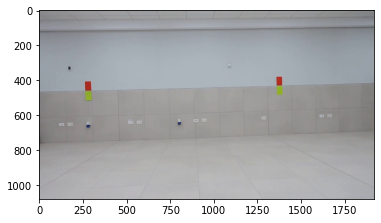

In [35]:
# cap = cv2.VideoCapture('/home/israel/Downloads/UCB/raw/090/32/3.mp4')
# cap.set(cv2.CAP_PROP_POS_FRAMES, 150)
# ret, frame = cap.read()
# plt.imshow(frame[:,:,::-1])

# cv2.imwrite('/home/israel/Downloads/UCB/clips/090/022/nm/background.png', frame)
# cv2.imwrite('/home/israel/Downloads/UCB/clips/090/022/bg/background.png', frame)
# cv2.imwrite('/home/israel/Downloads/UCB/clips/090/022/cl/background.png', frame)

In [117]:
# Necesary to eliminate the clips of less than 0.5 MB since they are empty
for subject in sorted(os.listdir(clips_directory)):
    sub_dir = os.path.join(clips_directory, subject)
    walks = os.listdir(sub_dir)

    for walk in walks:
        walk_dir = os.path.join(clips_directory, subject, walk)
        files = os.listdir(walk_dir)
        video_files = []
        for file in files:
            if file[-4:] == '.avi':
                file_path = os.path.join(clips_directory, subject, walk,file)
                if os.path.getsize(file_path)/(1000000)<1:
                    print(f'Deleting: {subject} - {file}')
                    os.remove(file_path)

## BACKGROUND SUBSTRACTION

In [27]:
images_dir = '/home/israel/Downloads/UCB/frames/'
frs_dir = 'rgb/'
mks_dir = 'masks/'
verbose = False

nclips = {'nm':6, 'bg':4, 'cl':4}

In [32]:
for view in views:
    frames_dir = os.path.join(images_dir, view, frs_dir)
    masks_dir = os.path.join(images_dir, view, mks_dir)
    print(f'PROCESSING VIEW: {view}')
    subjects = sorted(os.listdir(os.path.join(clips_directory, view)))[2:]
    for subject in subjects:
#     for subject in ['002']:
        print(f'Processing subject: {subject} view: {view}                        ')
        create_dir(os.path.join(frames_dir, subject), force=True)
        create_dir(os.path.join(masks_dir, subject), force=True)

        subject_dir = os.path.join(clips_directory, view, subject)
        walks = os.listdir(subject_dir)
        
        for j, walk in enumerate(['nm', 'bg', 'cl']):
            walk_dir = os.path.join(subject_dir, walk)
            background = cv2.imread(os.path.join(walk_dir, f'background.png'))
            clips = sorted(os.listdir(walk_dir))
            
            save_back_path = os.path.join(frames_dir, subject, f'{walk}-background.png')
            cv2.imwrite(save_back_path, background)
            
            for i, clip in enumerate(clips):
                if clip[-4:] == '.avi' and nclips[walk]>=i:
                    clip_path = os.path.join(walk_dir, clip)
                    sub_dir = os.path.join(frames_dir, subject, walk, clip.split('.')[0])
                    mask_dir = os.path.join(masks_dir, subject, walk, clip.split('.')[0])
                    create_dir(sub_dir, force=True)
                    create_dir(mask_dir, force=True)
                    print(sub_dir, end='\r')
                    cap = cv2.VideoCapture(clip_path)
                    cnt = 0
                    while True:
                        ret, frame = cap.read()
                        if ret:
                            ok, diff_gray, closed, blured = bkgrd_Lab_substraction(frame, background)
                            if ok:
                                cnt +=1
                                frame_path = f'{sub_dir}/{str(cnt).zfill(4)}.png'
                                mask_path = f'{mask_dir}/{str(cnt).zfill(4)}.png'
                                cv2.imwrite(frame_path, frame)
                                cv2.imwrite(mask_path, closed)
                                if verbose:
                                    masked = apply_mask(frame.copy(), closed.astype('bool'), color)
                                    cv2.imshow('frame', masked)
                        else:
                            break
                        if cv2.waitKey(1) == ord('q'):
                            break
                    cap.release()
    print('', end="\r")
cv2.destroyAllWindows()

PROCESSING VIEW: 090
Processing subject: 003 view: 090                        
Processing subject: 004 view: 090                        
Processing subject: 005 view: 090                        
Processing subject: 006 view: 090                        
Processing subject: 007 view: 090                        
Processing subject: 008 view: 090                        
Processing subject: 010 view: 090                        
Processing subject: 011 view: 090                        
Processing subject: 012 view: 090                        
Processing subject: 013 view: 090                        
Processing subject: 014 view: 090                        
Processing subject: 015 view: 090                        
Processing subject: 016 view: 090                        
Processing subject: 017 view: 090                        
Processing subject: 018 view: 090                        
Processing subject: 019 view: 090                        
Processing subject: 020 view: 090                  

## Visualization
Let's visualize the results and masking a single frame of each sequence

SHOWING VIEW: 090
Showing subject: 001 view: 090


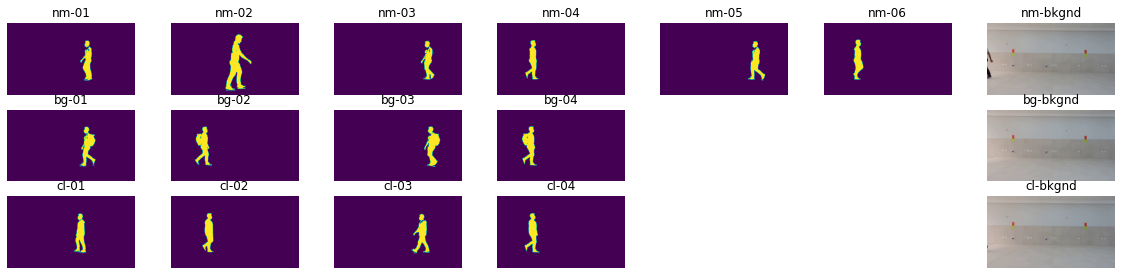

Showing subject: 002 view: 090


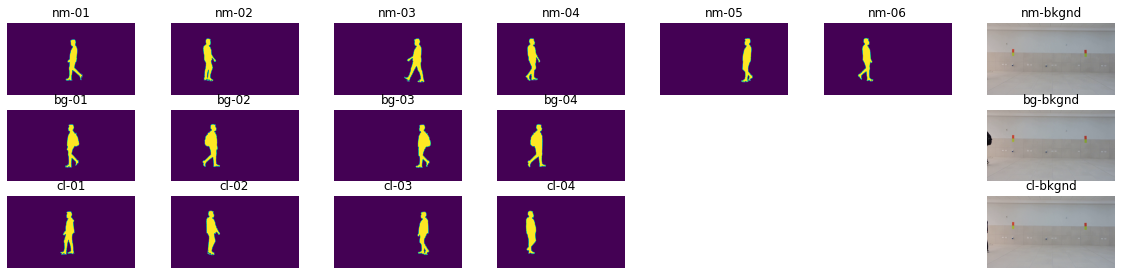

Showing subject: 003 view: 090


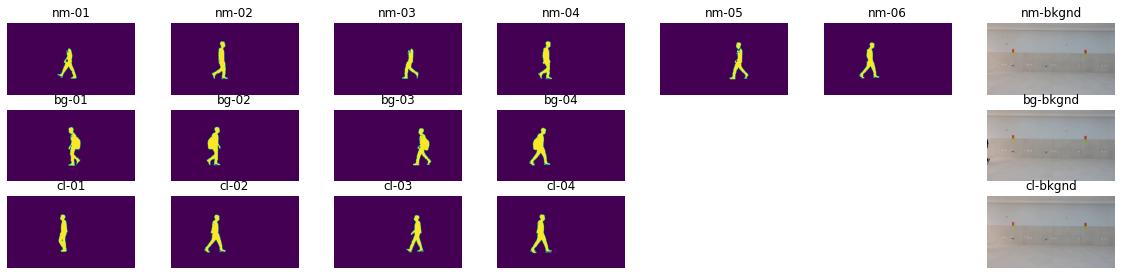

Showing subject: 004 view: 090


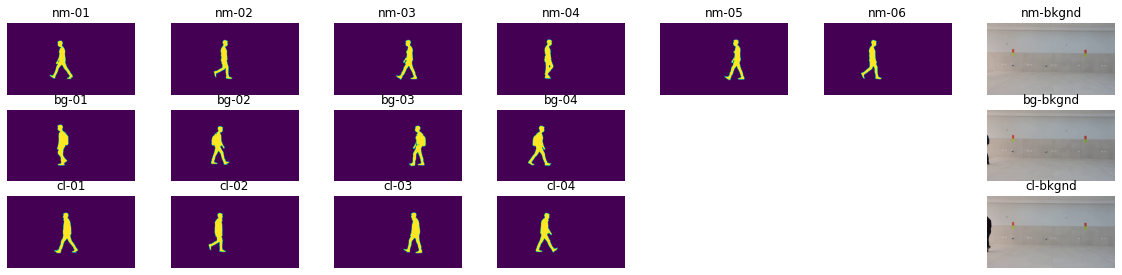

Showing subject: 005 view: 090


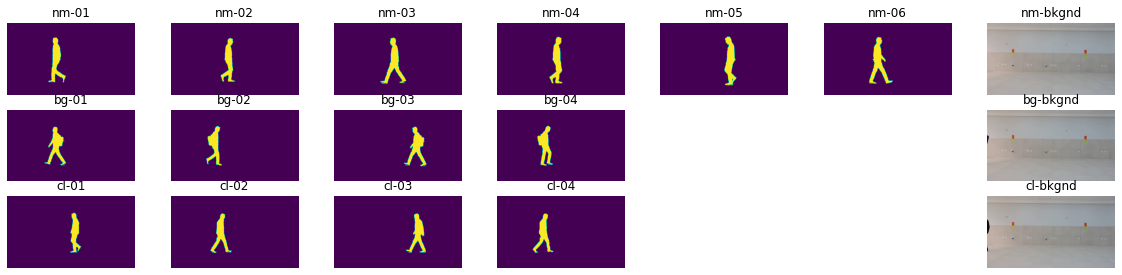

Showing subject: 006 view: 090


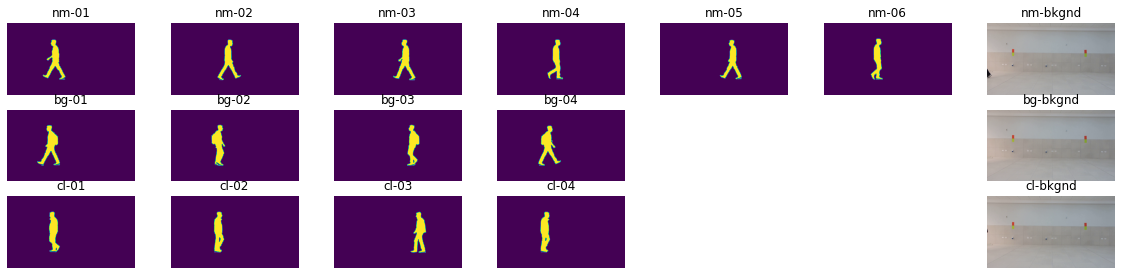

Showing subject: 007 view: 090


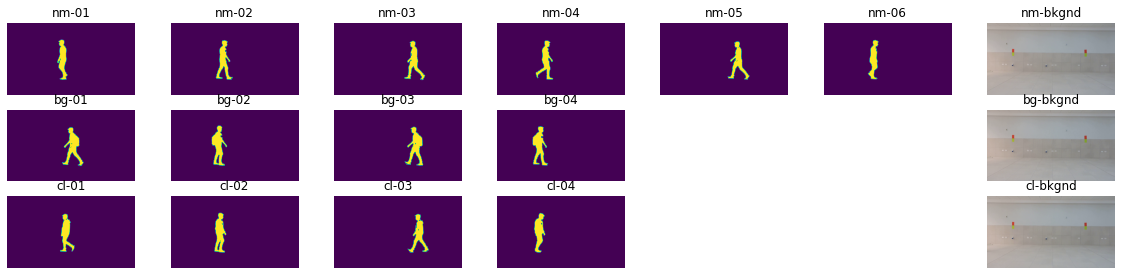

Showing subject: 008 view: 090


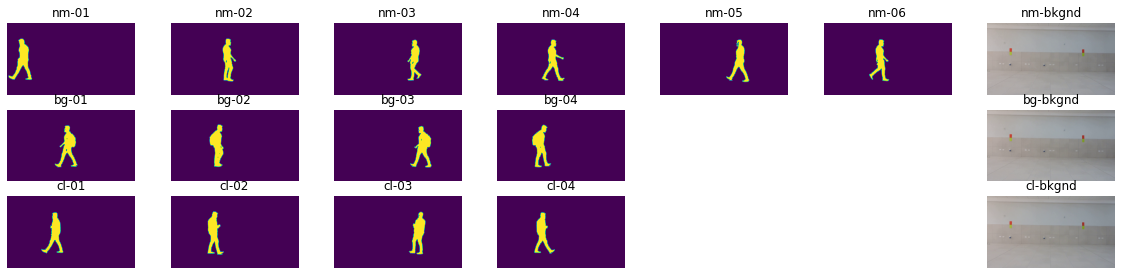

Showing subject: 010 view: 090


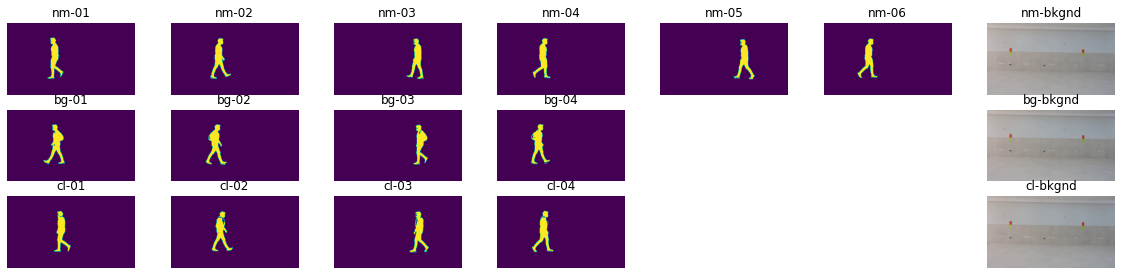

Showing subject: 011 view: 090


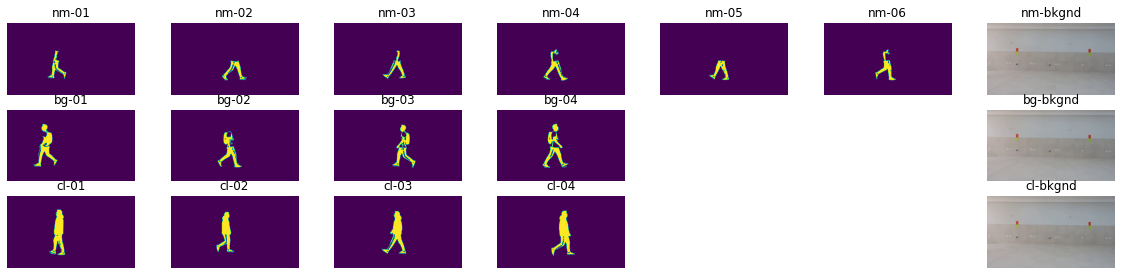

Showing subject: 012 view: 090


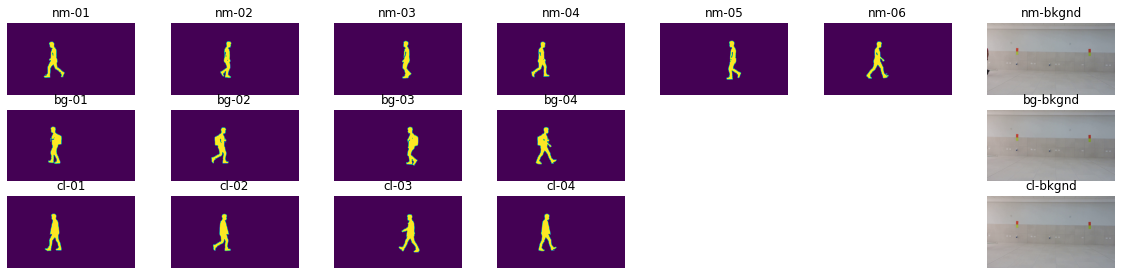

Showing subject: 013 view: 090


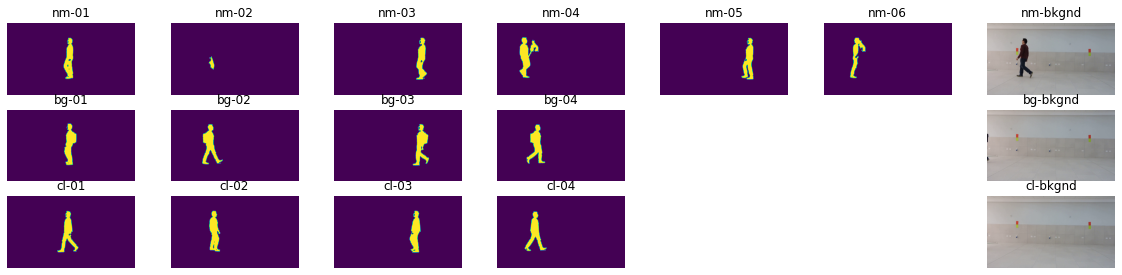

Showing subject: 014 view: 090


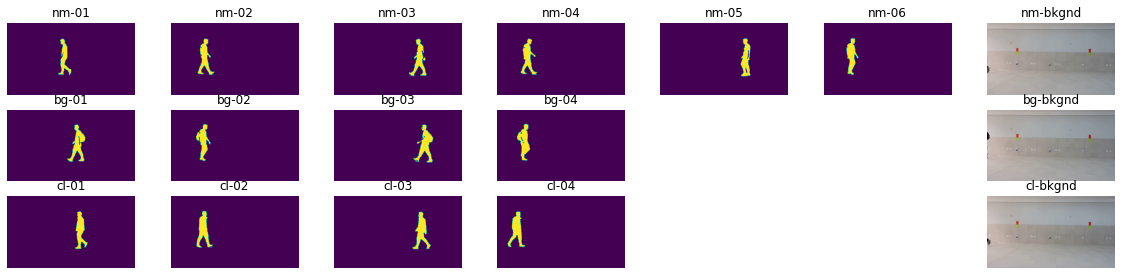

Showing subject: 015 view: 090


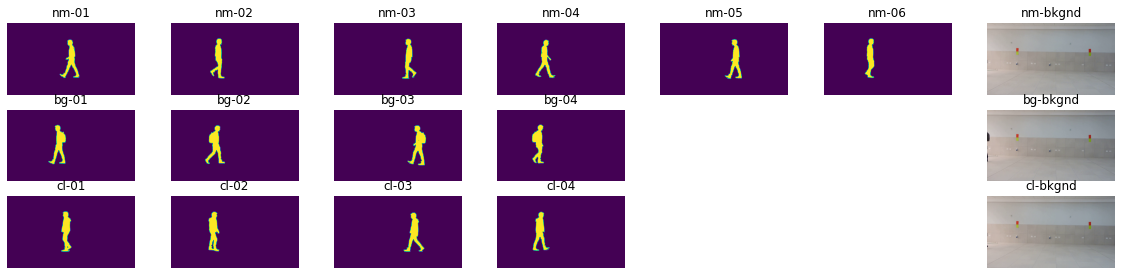

Showing subject: 016 view: 090


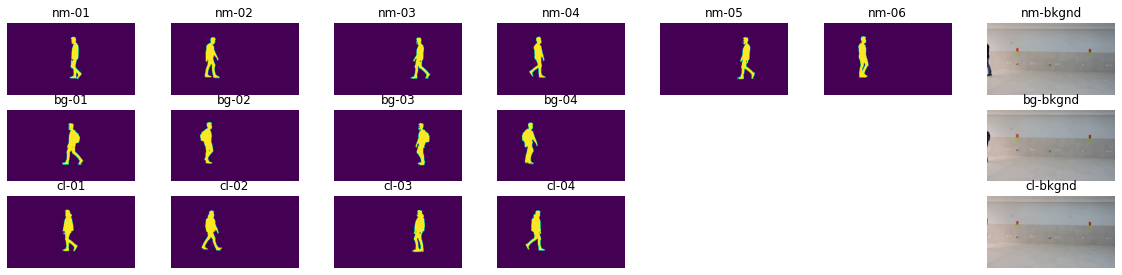

Showing subject: 017 view: 090


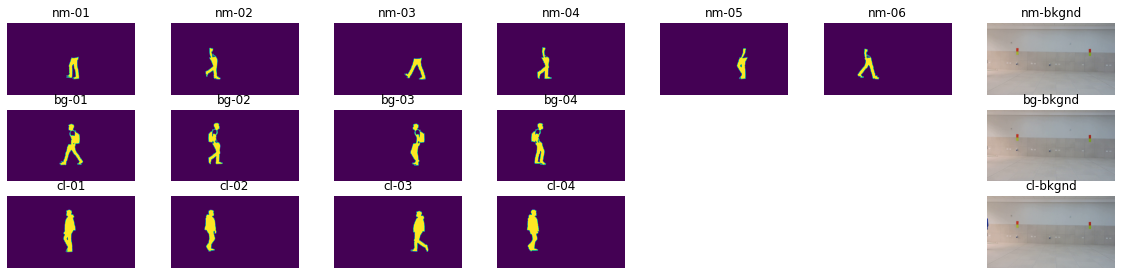

Showing subject: 018 view: 090


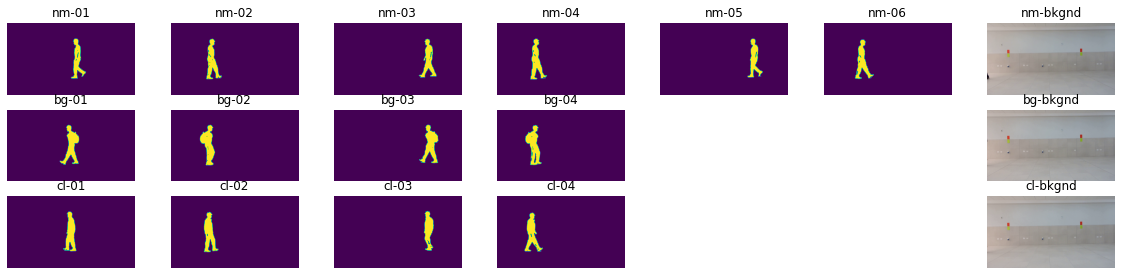

Showing subject: 019 view: 090


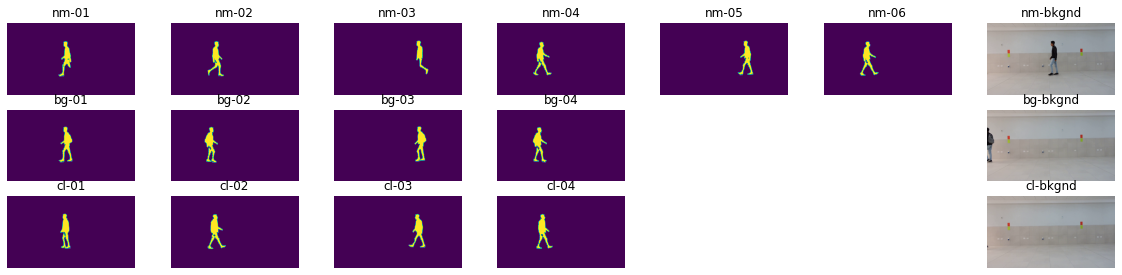

Showing subject: 020 view: 090


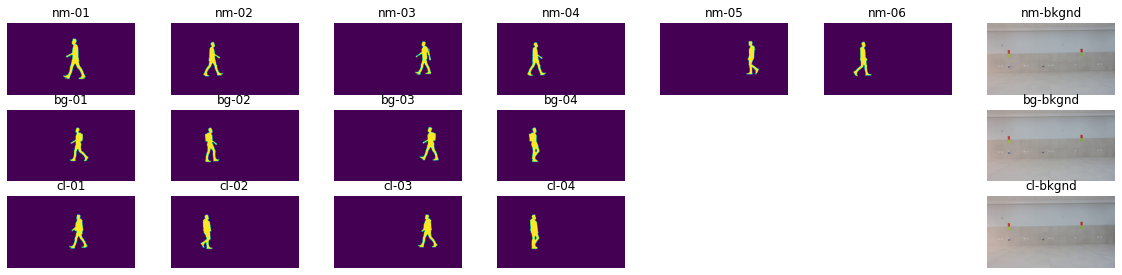

Showing subject: 021 view: 090


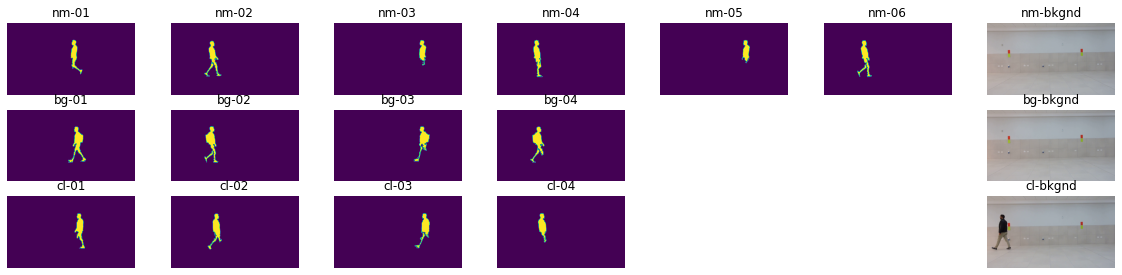

Showing subject: 022 view: 090


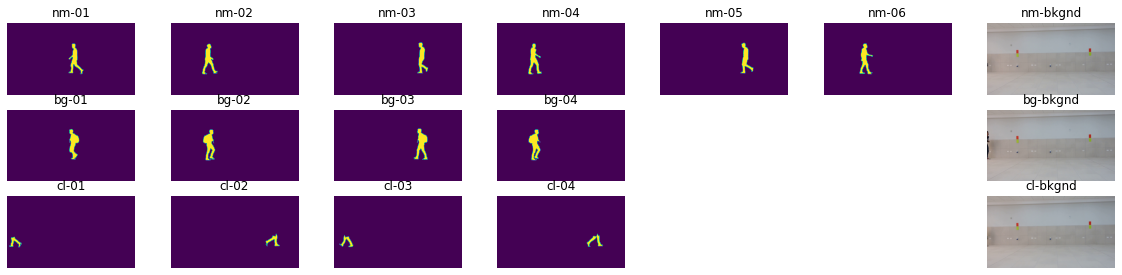

Showing subject: 023 view: 090


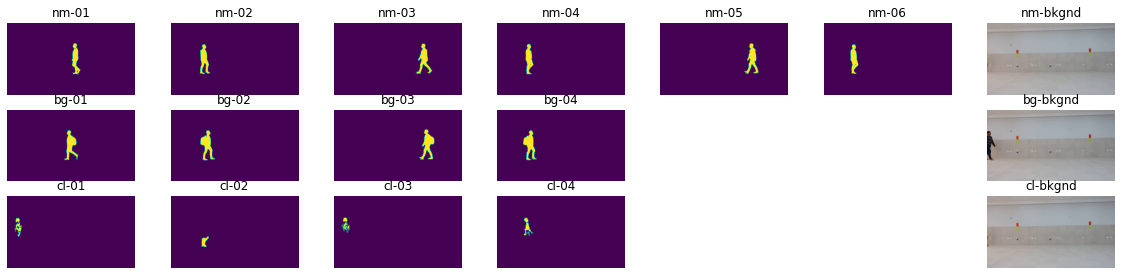

Showing subject: 024 view: 090


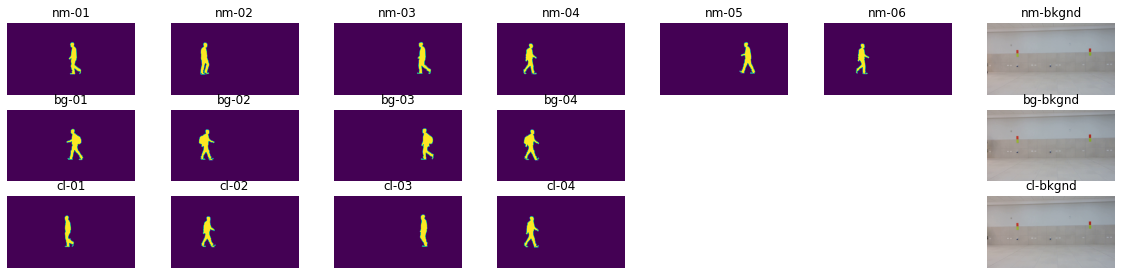

Showing subject: 025 view: 090


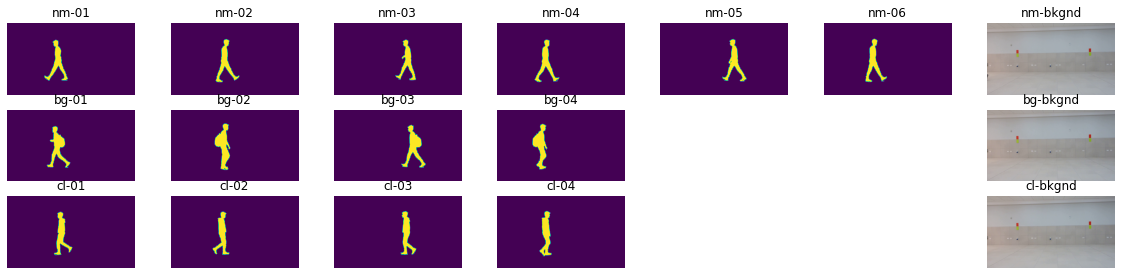

Showing subject: 026 view: 090


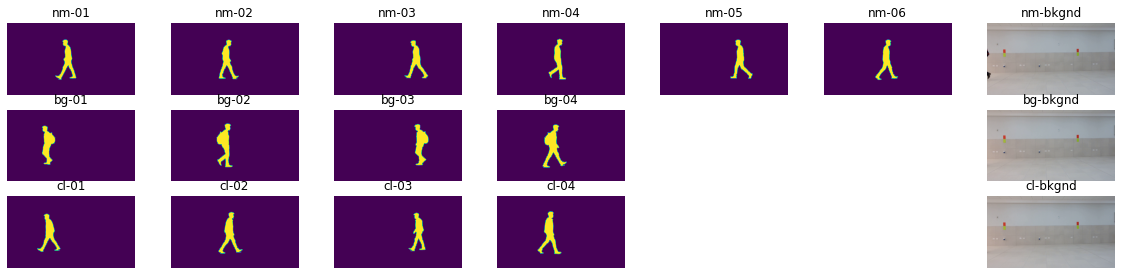

Showing subject: 027 view: 090


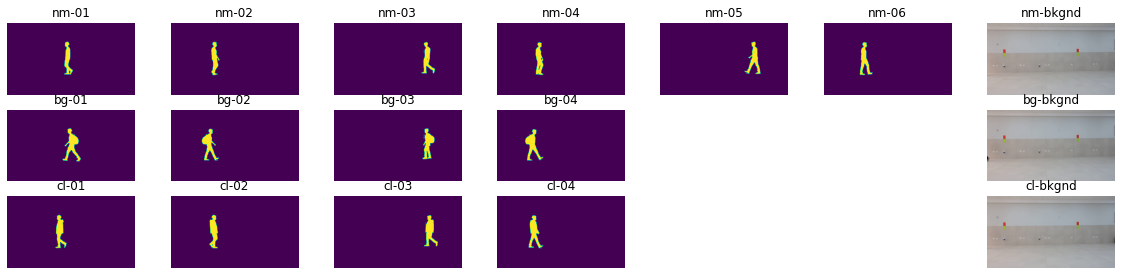

Showing subject: 028 view: 090


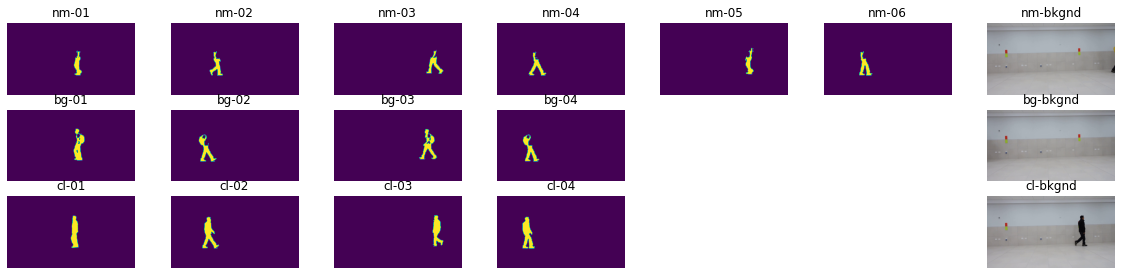

Showing subject: 029 view: 090


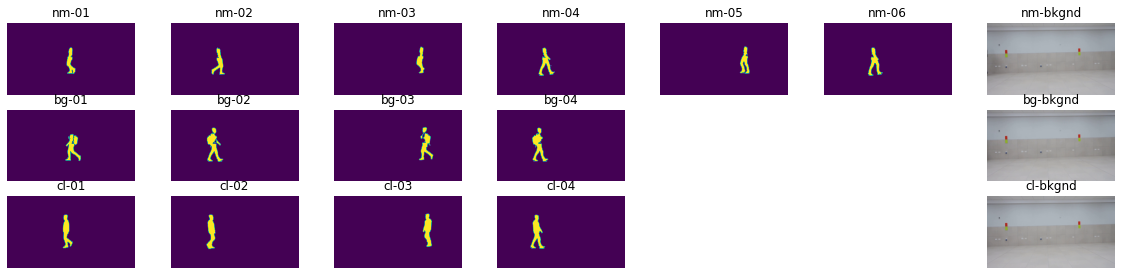

Showing subject: 030 view: 090


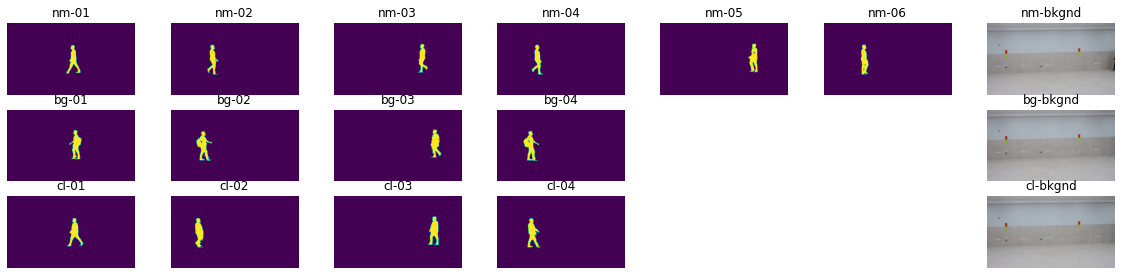

Showing subject: 031 view: 090


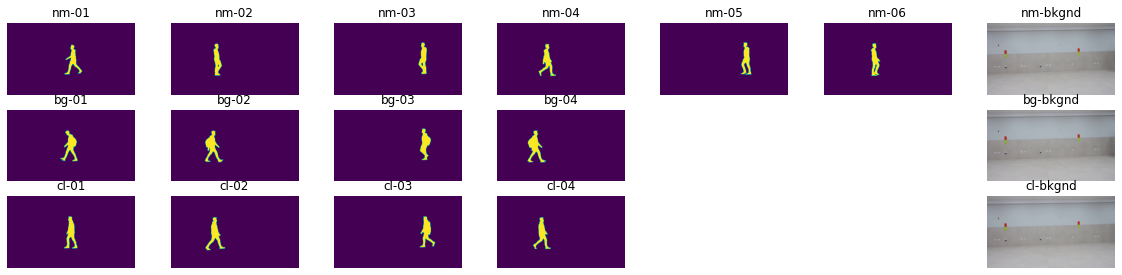

Showing subject: 032 view: 090


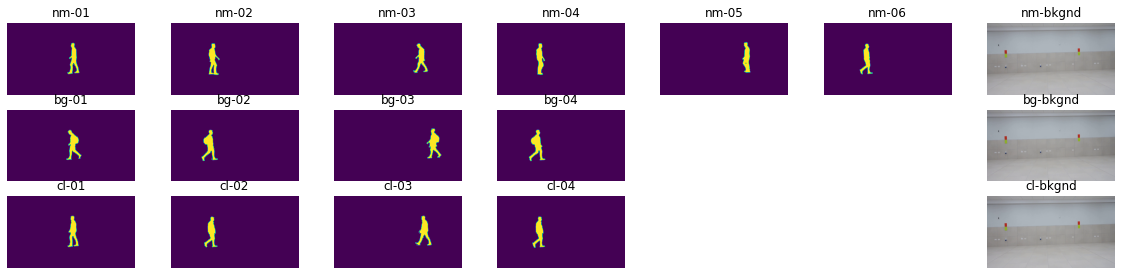

Showing subject: 033 view: 090


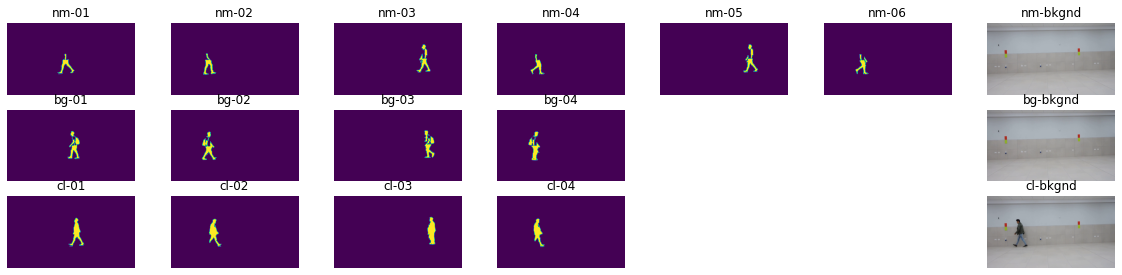

Showing subject: 034 view: 090


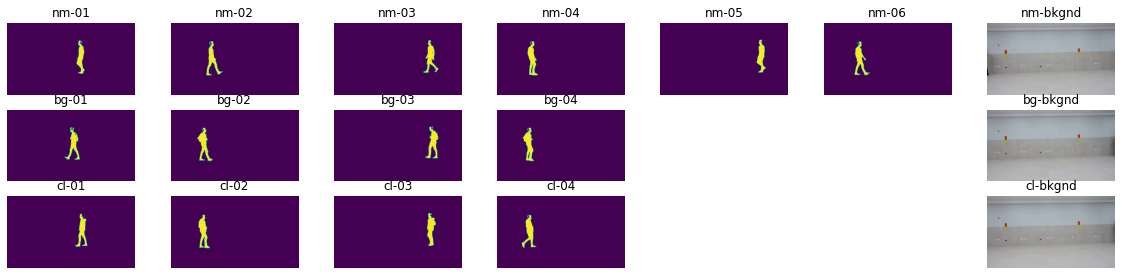

Showing subject: 035 view: 090


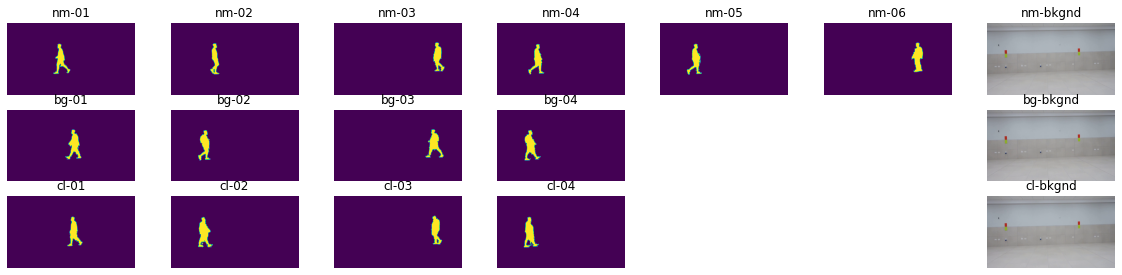

Showing subject: 036 view: 090


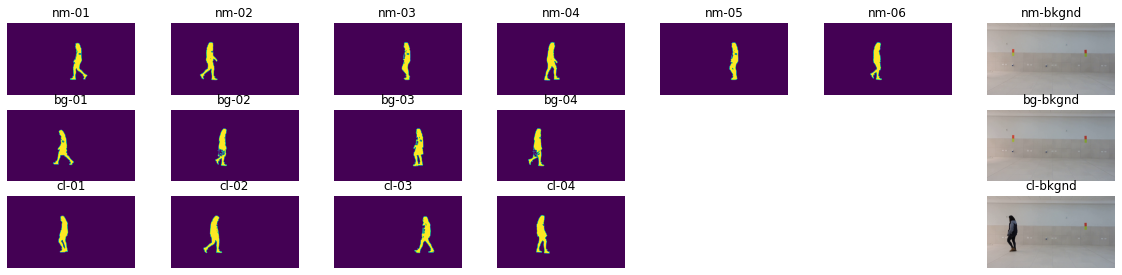

Showing subject: 037 view: 090


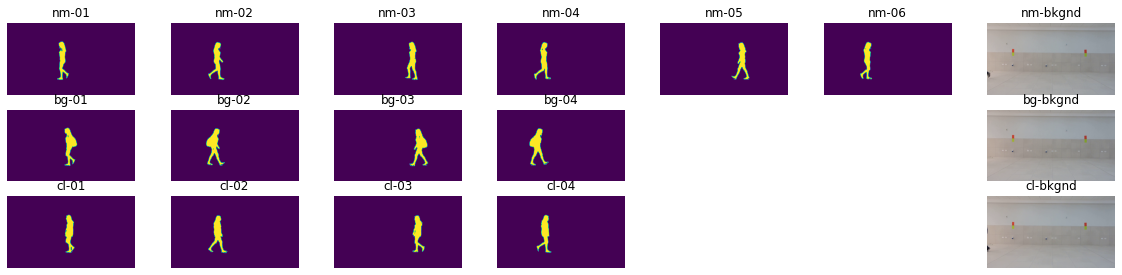

Showing subject: 038 view: 090


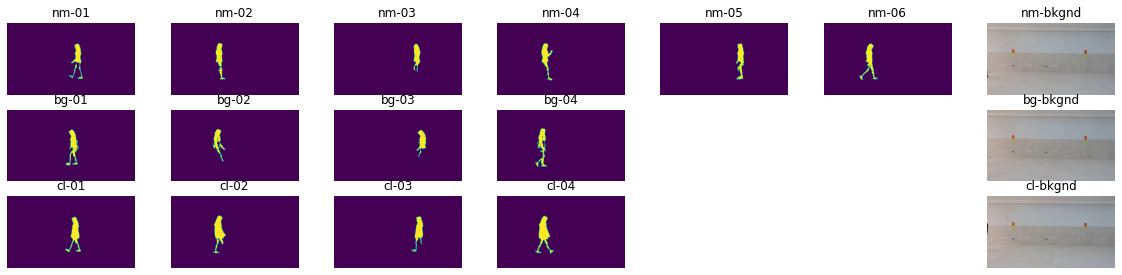

Showing subject: 039 view: 090


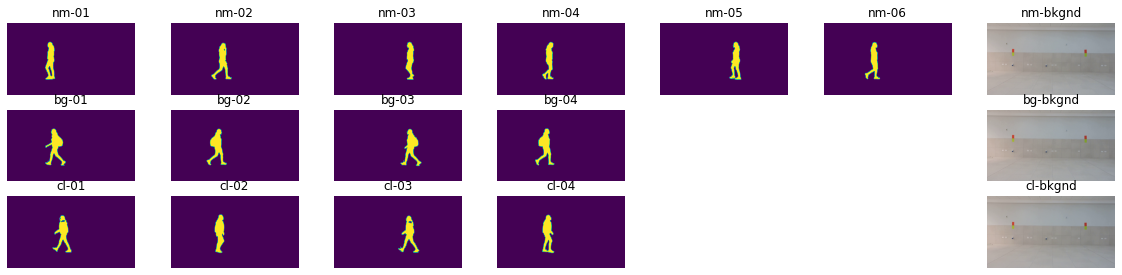

Showing subject: 040 view: 090


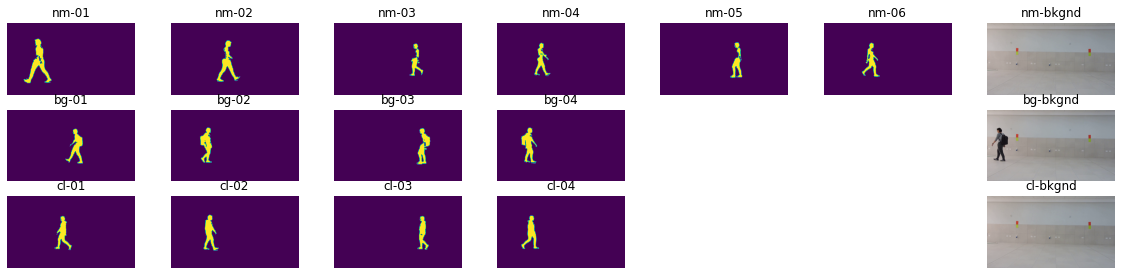

Showing subject: 041 view: 090


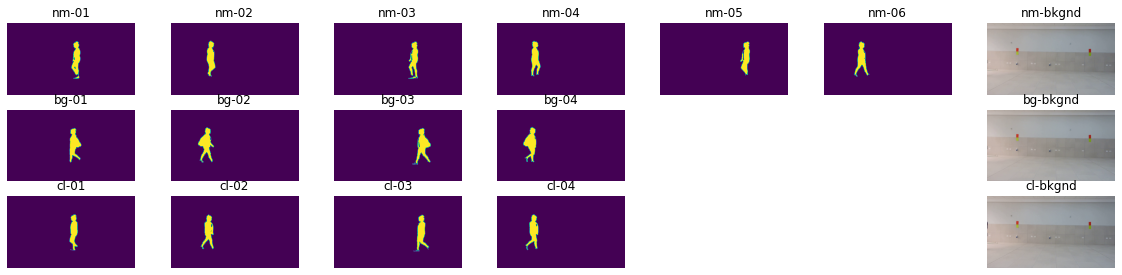

Showing subject: 042 view: 090


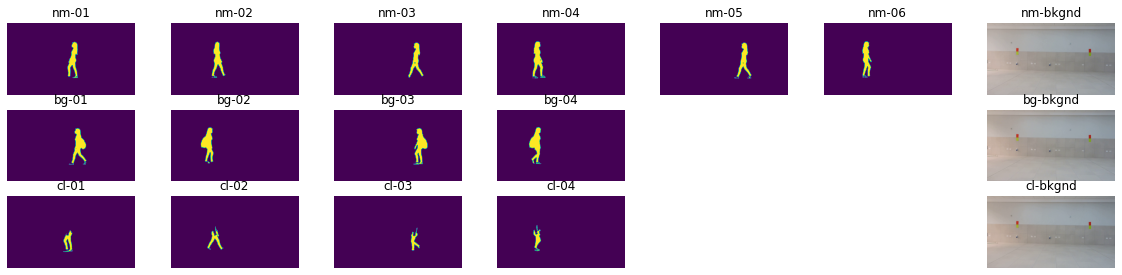

Showing subject: 043 view: 090


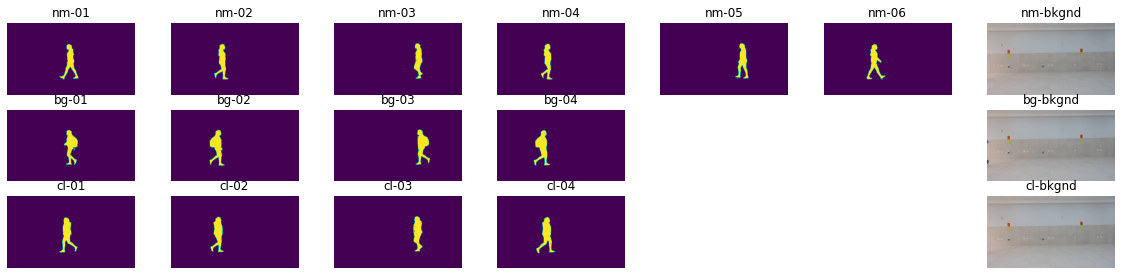

Showing subject: 044 view: 090


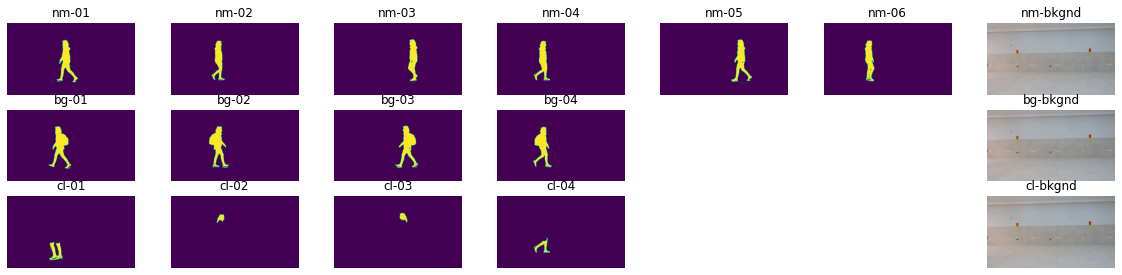

Showing subject: 045 view: 090


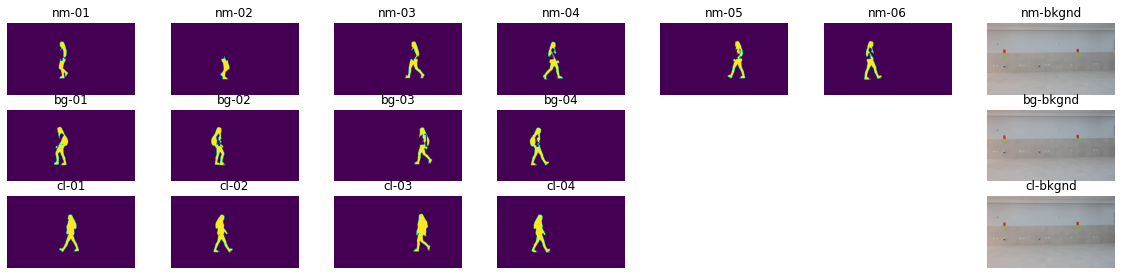

Showing subject: 046 view: 090


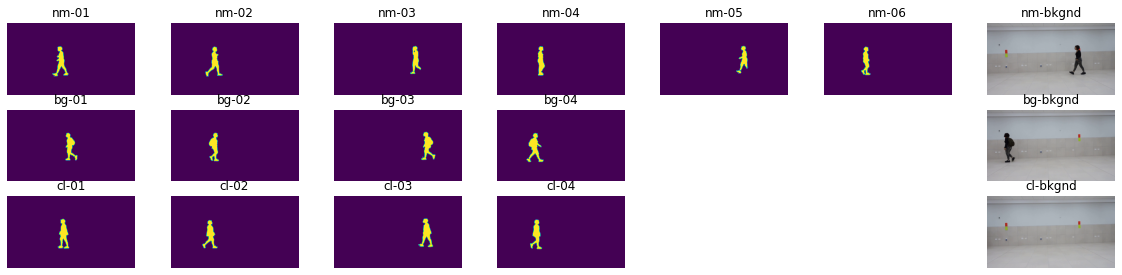

Showing subject: 047 view: 090


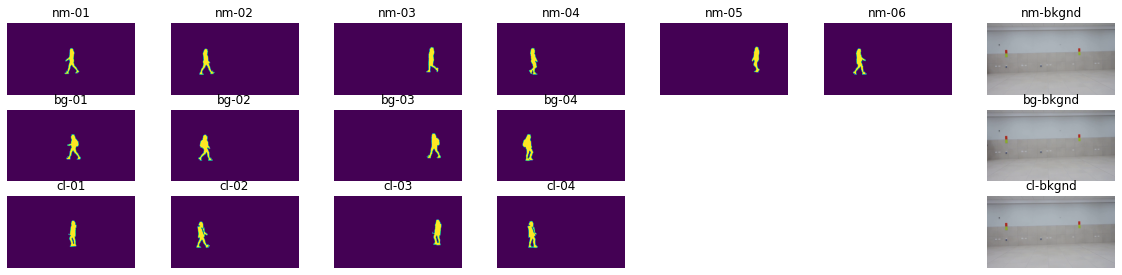

Showing subject: 048 view: 090


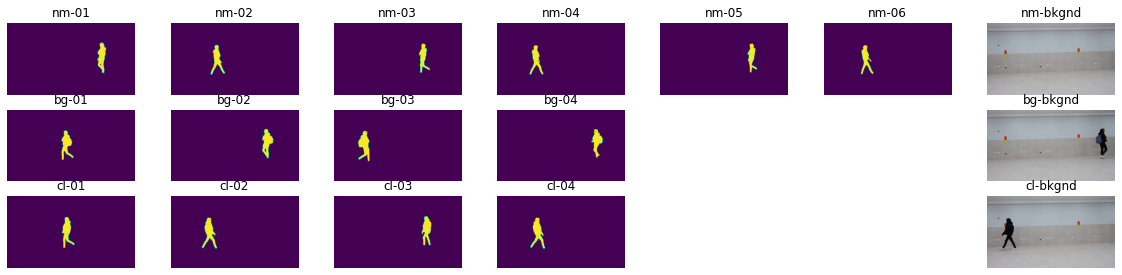

Showing subject: 049 view: 090


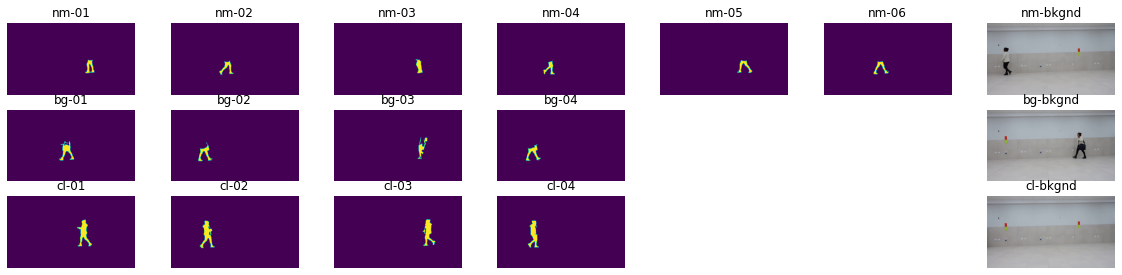

Showing subject: 050 view: 090


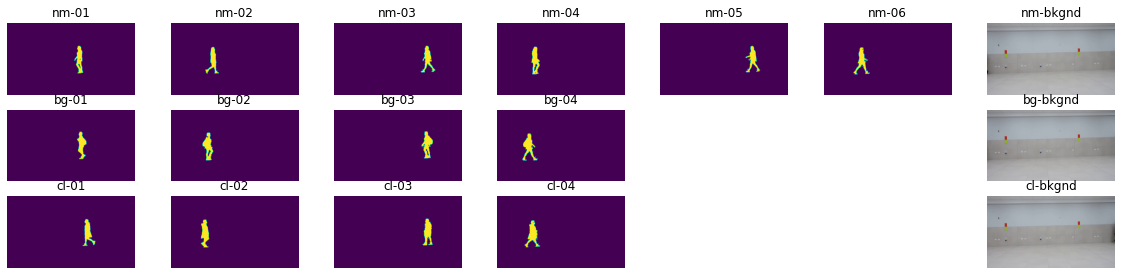

Showing subject: 051 view: 090


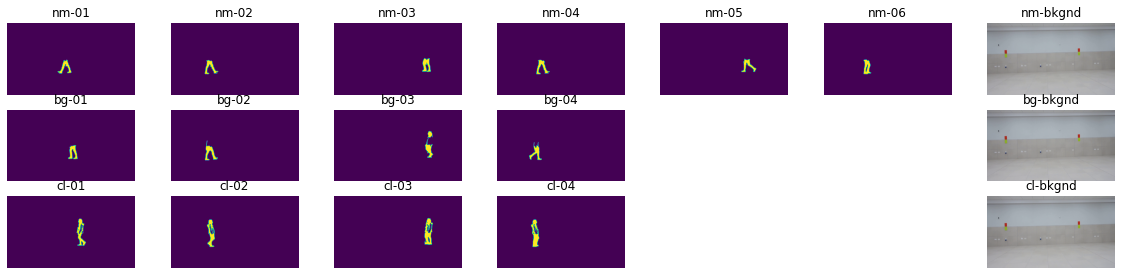

Showing subject: 052 view: 090


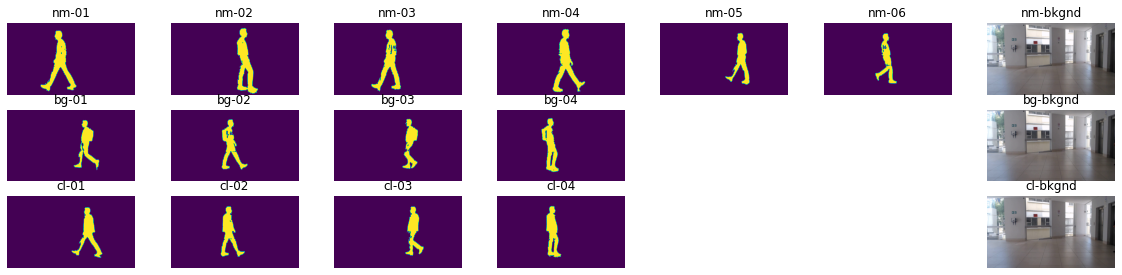

Showing subject: 052a view: 090


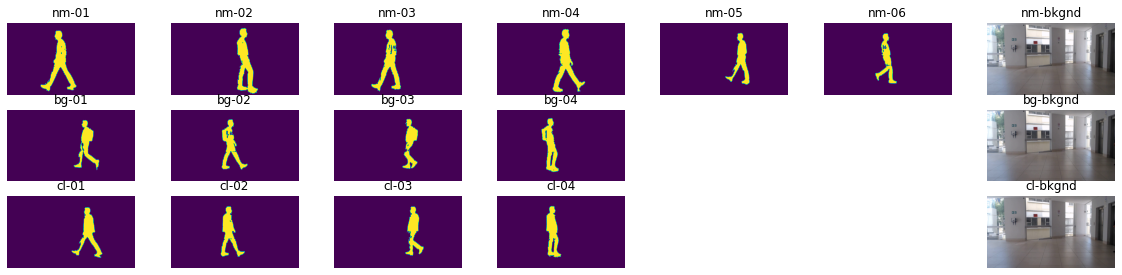

Showing subject: 053 view: 090


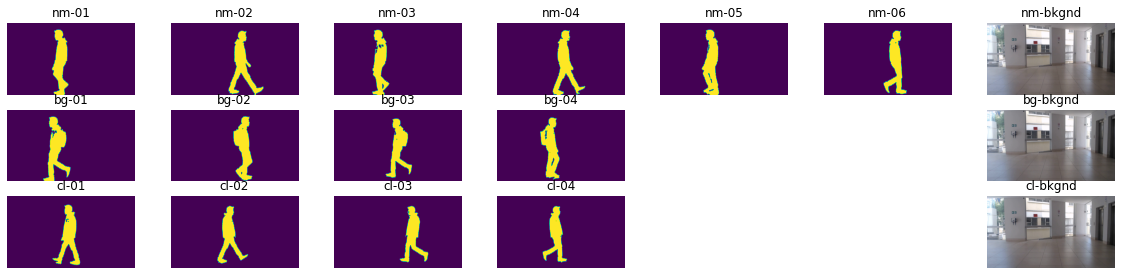

Showing subject: 053a view: 090


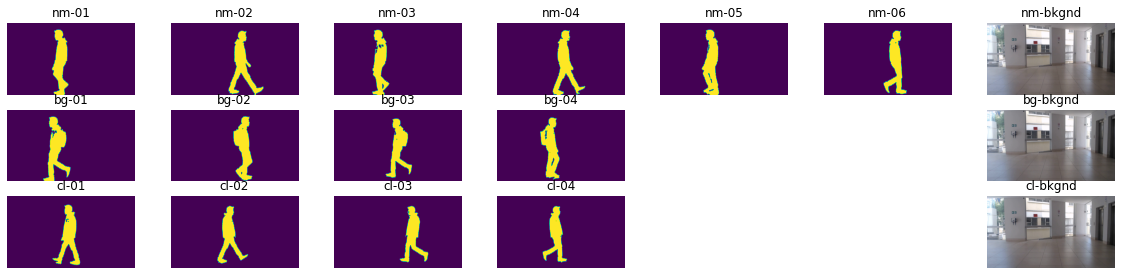

In [34]:
for view in views:
    frames_dir = os.path.join(images_dir, view, frs_dir)
    masks_dir = os.path.join(images_dir, view, mks_dir)
    print(f'SHOWING VIEW: {view}')
    subjects = sorted(os.listdir(frames_dir))
    for subject in subjects:
#     for subject in ['023']:
        print(f'Showing subject: {subject} view: {view}')

        plt.figure(figsize=(20, 4.5))
#         plt.subplots_adjust(wspace=0.1, hspace=0.01)
        for j, walk in enumerate(['nm', 'bg', 'cl']):
            nplot = j*7 + 1
            rseqs_dir = os.path.join(frames_dir, subject, walk)
            mseqs_dir = os.path.join(masks_dir, subject, walk)
            
            seqs = sorted(os.listdir(rseqs_dir))
            bkgnd_path = os.path.join(frames_dir, subject, f'{walk}-background.png')
#             print(bkgnd_path)
            bkgnd = cv2.imread(bkgnd_path)
            plt.subplot(3, 7, 7*(j+1)); plt.imshow(bkgnd[:,:,::-1]); plt.title(f'{walk}-bkgnd'); plt.axis('off')
            for i, seq in enumerate(seqs):
#                 rgb = cv2.imread(os.path.join(rseqs_dir, seq, f'{str(40).zfill(4)}.png'))
                msk = cv2.imread(os.path.join(mseqs_dir, seq, f'{str(40).zfill(4)}.png'), 0)
#                 plt.subplot(3, 7, nplot); plt.imshow(msk[:,:,::-1]); plt.title(seq); plt.axis('off')
                plt.subplot(3, 7, nplot); plt.imshow(msk); plt.title(seq); plt.axis('off')
                
                nplot+=1
        plt.show()

In [34]:
os.path.exists('/home/israel/Downloads/UCB/frames/090/rgb/022/nm-background.png')

True

## GEI Generation

In [9]:
def GEI_generator(sil_file, size = 64,debug = False):
    lfiles = sorted(os.listdir(sil_file))
    stack_GEI = []
    if debug:
        print(f'Number of images: {len(lfiles)}')
        plt.figure(figsize=(20,int(len(lfiles)/10)))
    for idimg, path in enumerate(lfiles):
        if debug: 
            plt.subplot((len(lfiles)//15)+1,15, idimg+1)
        img = cv2.imread(os.path.join(sil_file, path), 0)
        # Silhouette extraction
        if img.mean() > 5:
            x, y, w, h = cv2.boundingRect(img)
            silhouette = img[y:y+h,x:x+w]

            # Normalizae silhouette
            factor = size/max(silhouette.shape)
            height = round(factor*silhouette.shape[0])
            width = round(factor*silhouette.shape[1])
            if(height>width):
                nor_sil = cv2.resize(silhouette,(width,height))
                # We add a background of the shape size x size
                # We take the upper part of the body to center the image and avoid the legs
                portion_body = 0.3
                moments = cv2.moments(nor_sil[0:int(nor_sil.shape[0]*portion_body),])
                w = round(moments['m10']/moments['m00'])
                background = np.zeros((size, size))
                shift = round((size/2)-w)
                if(shift<0 or shift+nor_sil.shape[1]>size): shift = round((size-nor_sil.shape[1])/2)
                background[:,shift:nor_sil.shape[1]+shift] = nor_sil

                stack_GEI.append(background)
                if debug:
                    plt.imshow(background,'gray'); plt.title(idimg);plt.axis('off')
                    # plt.subplots_adjust(wspace=0.05, hspace=0.01)
    if stack_GEI == []:
        GEI = np.zeros((size, size))
        print('No Files Found')
        return False, GEI, stack_GEI
    else: 
        GEI = np.mean(np.array(stack_GEI),axis=0)
        return True, GEI, stack_GEI
    

In [30]:
images_dir = '/home/israel/Downloads/UCB/frames/'
representations_dir = '/home/israel/Downloads/UCB/representations/'
frs_dir = 'rgb/'
mks_dir = 'masks/'
verbose = False

In [45]:
for view in views:
    frames_dir = os.path.join(images_dir, view, frs_dir)
    masks_dir = os.path.join(images_dir, view, mks_dir)
    rep_dir = os.path.join(representations_dir, view)
    print(f'GENERATING GAIT REPRESENTATIONS FROM VIEW: {view}')
    subjects = sorted(os.listdir(os.path.join(images_dir, view, frs_dir)))[15:]
#     for subject in subjects:
    for subject in ['022', '023', '025']:
        print(f'Processing subject: {subject} view: {view}')
        sub_GEI_dir = os.path.join(rep_dir, subject)
        create_dir(sub_GEI_dir, force=True)

        for j, walk in enumerate(['nm', 'bg', 'cl']):
            seq_dir = os.path.join(masks_dir, subject, walk)
            seqs = sorted(os.listdir(seq_dir))
            print(f'Processing: {seqs}')
            for s, seq in enumerate(seqs):
                seq_frames_dir = os.path.join(seq_dir, seq)
                ret, GEI, _ = GEI_generator(seq_frames_dir)
                if ret:
                    GEI_name = os.path.join(sub_GEI_dir, f'{walk}-{str(s).zfill(2)}.png')
                    cv2.imwrite(GEI_name, GEI)
                else:
                    break

GENERATING GAIT REPRESENTATIONS FROM VIEW: 090
Processing subject: 022 view: 090
Processing: ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']
Processing: ['bg-01', 'bg-02', 'bg-03', 'bg-04']
Processing: ['cl-01', 'cl-02', 'cl-03', 'cl-04']
No Files Found
Processing subject: 023 view: 090
Processing: ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']
Processing: ['bg-01', 'bg-02', 'bg-03', 'bg-04']
Processing: ['cl-01', 'cl-02', 'cl-03', 'cl-04']
No Files Found
Processing subject: 025 view: 090
Processing: ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06', 'nm-07', 'nm-08', 'nm-09', 'nm-10', 'nm-11', 'nm-12', 'nm-13', 'nm-14']
Processing: ['bg-01', 'bg-02', 'bg-03', 'bg-04']
Processing: ['cl-01', 'cl-02', 'cl-03', 'cl-04']


## GEI Visualization

In [31]:
for view in views:
    print(f'SHOWING VIEW: {view}')
    rep_dir = os.path.join(representations_dir, view)
    subjects = sorted(os.listdir(rep_dir))
    for subject in subjects:
#     for subject in ['002']:
        print(f'Showing subject: {subject} view: {view}')
        plt.figure(figsize=(12, 4.5))
        nsec = 1
        for j, walk in enumerate(['nm', 'bg', 'cl']):
            seqs = sorted(glob(os.path.join(representations_dir, view, subject)+f'/{walk}*'))[:nclips[walk]]
            for i, seq in enumerate(seqs):
                GEI = cv2.imread(seq)
                
                plt.subplot(3, 6, j*6+(i+1)); plt.imshow(GEI, 'gray'); plt.title(seq.split('/')[-1]); plt.axis('off')
        plt.show()

SHOWING VIEW: 090
Showing subject: 001 view: 090


NameError: name 'glob' is not defined

<Figure size 864x324 with 0 Axes>

# Classification

In [80]:
representations_dir = '/home/israel/Downloads/UCB/representations/'
frs_dir = 'rgb/'
mks_dir = 'masks/'
verbose = False

In [116]:
def GEI2MGEI(GEI, fr, to):
    GEI[fr:to]==0
    return GEI

In [136]:
training = {'data':[], 'labels': [], 'seqs':['nm-00', 'nm-01', 'nm-02', 'nm-03', 'cl-00', 'bg-00', 'cl-01', 'bg-01']}
testing = {'nm':{'data':[], 'labels': [], 'seqs': ['nm-04', 'nm-05']},
           'cl':{'data':[], 'labels': [], 'seqs': ['cl-02', 'cl-03']},
           'bg':{'data':[], 'labels': [], 'seqs': ['bg-02', 'bg-03']}}

fr = int(h * 0.15)
to = int(h * 0.60)
for view in views:
    rep_dir = os.path.join(representations_dir, view)
    print(f'GENERATING GAIT REPRESENTATIONS FROM VIEW: {view}')
    subjects = sorted(os.listdir(rep_dir))
    skip_sub = ['022', '023']
    
    for subject in subjects:
#     for subject in ['001']:
        if subject not in skip_sub:
            print(f'Processing subject: {subject} view: {view}')
            sub_GEI_dir = os.path.join(rep_dir, subject)

            for seq_tr in training['seqs']:
                walk = seq_tr.split('-')[0]
                GEI_name = os.path.join(sub_GEI_dir, f'{seq_tr}.png')
                GEI = GEI2MGEI(cv2.imread(GEI_name, 0),fr,to).flatten()
                training['data'].append(GEI)
                training['labels'].append(int(subject))
    #             print(GEI_name)

            for walk, dic in testing.items():
                for seq_tr in dic['seqs']:
                    GEI_name = os.path.join(sub_GEI_dir, f'{seq_tr}.png')
#                     print(GEI_name, end='\r')
                    GEI = GEI2MGEI(cv2.imread(GEI_name, 0),fr, to).flatten()
                    dic['data'].append(GEI)
                    dic['labels'].append(int(subject))

GENERATING GAIT REPRESENTATIONS FROM VIEW: 090
Processing subject: 001 view: 090
Processing subject: 002 view: 090
Processing subject: 006 view: 090
Processing subject: 010 view: 090
Processing subject: 011 view: 090
Processing subject: 012 view: 090
Processing subject: 013 view: 090
Processing subject: 014 view: 090
Processing subject: 015 view: 090
Processing subject: 016 view: 090
Processing subject: 017 view: 090
Processing subject: 018 view: 090
Processing subject: 019 view: 090
Processing subject: 020 view: 090
Processing subject: 021 view: 090
Processing subject: 024 view: 090
Processing subject: 025 view: 090
Processing subject: 026 view: 090
Processing subject: 027 view: 090
Processing subject: 052 view: 090
Processing subject: 053 view: 090


# Classification

In [137]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [139]:
trainX = np.array(training['data'])
trainY = np.array(training['labels'])

# Escalamos los datos
scaler = StandardScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)

print(f'Training shape: {trainX.shape} | Testing shape {trainY.shape}')

_ ,componentes_original = trainX.shape

# Aplicamos PCA
pre = 0.9999
pca = PCA(pre)
pca.fit(trainX)
componentes_PCA = pca.n_components_
print(f'Com Init : {componentes_original} Comp PCA: {componentes_PCA} Preservando: {pre*100}')
trainX = pca.transform(trainX)

# Declaramos el modelo y lo ajustamos
# logisticRegr = LogisticRegression(solver = 'lbfgs',C=0.1,tol=0.0000001)
# logisticRegr = KNeighborsClassifier(n_neighbors=1)
# logisticRegr = SVC(probability=True)
logisticRegr = LinearDiscriminantAnalysis(solver = 'lsqr',shrinkage=0.2)
logisticRegr.fit(trainX, trainY)


# Calculamos su score
score = logisticRegr.score(trainX, trainY)
print('Dataset: Train',' shape test: ',trainX.shape,' correcto: ',np.round(score,4))
# Realizamos pruebas en los datasets de testeo
# datasets = np.array(['test_nm_','test_bg_','test_cl_'])
for i in range(len(datasets)):
    testX = np.array(testing['bg']['data'])
    testY = np.array(testing['bg']['labels'])


    testX = scaler.transform(testX)
    # testX = normalizacion2(testX,mean,st)
    testX = pca.transform(testX)

    # Calculamos su score
    score = logisticRegr.score(testX, testY)
    certeza = logisticRegr.predict(testX)

    # Mostramos la matriz de confusion
    # print(confusion_matrix(certeza,testY))
    print('Shape test: ',testX.shape,' correcto: ',np.round(score,4))

Training shape: (168, 4096) | Testing shape (168,)
Com Init : 4096 Comp PCA: 165 Preservando: 99.99
Dataset: Train  shape test:  (168, 165)  correcto:  1.0
Shape test:  (42, 165)  correcto:  1.0


In [86]:
proba = logisticRegr.predict_proba(testX)

In [98]:
logisticRegr.classes_

array([ 1,  2,  6, 10, 11, 12, 13, 14, 15, 16])